In [1]:
import numpy
import shapely.geometry
import shapely.ops
from matplotlib import pyplot

In [2]:
def generate_rectangle_vertices(hx: float, hy: float, center: numpy.ndarray,
                                angle: float) -> numpy.ndarray:
    """Generate a rectangle polygon."""
    points = numpy.array([[hx, hy], [-hx, hy], [-hx, -hy], [hx, -hy]])
    points = points @ create_2D_rotation_matrix(angle).T
    points += center
    return points


def generate_rectangle(hx: float, hy: float, center: numpy.ndarray,
                       angle: float) -> shapely.geometry.Polygon:
    """Generate a rectangle polygon."""
    return shapely.geometry.Polygon(
        generate_rectangle_vertices(hx, hy, center, angle))

def create_2D_rotation_matrix(theta: float) -> numpy.ndarray:
    c, s = numpy.cos(theta), numpy.sin(theta)
    return numpy.array([[c, -s], [s, c]])

In [3]:
def generate_regular_ngon_vertices(n: int, radius: float) -> numpy.ndarray:
    """Generate the vertices of a regular N-gon centered at zero."""
    angles = (numpy.arange(n, dtype=float) * 2 * numpy.pi / n).reshape(-1, 1)
    return radius * numpy.hstack([numpy.cos(angles), numpy.sin(angles)])


def generate_ngon_edges(n: int) -> numpy.ndarray:
    """Generate the edges of a N-gon."""
    indices = numpy.arange(n).reshape(-1, 1)
    return numpy.hstack([indices, numpy.roll(indices, -1)])

In [76]:
def generate_cog(num_teeth, center_radius, taper=0.75, tooth_ratio=2):
    num_core_sides = 2 * num_teeth
    core_vertices = generate_regular_ngon_vertices(num_core_sides, center_radius)
    core_vertices = core_vertices @ create_2D_rotation_matrix(numpy.pi / num_core_sides).T
    side_length = numpy.linalg.norm(core_vertices[1] - core_vertices[0])
    tooth_vertices = generate_rectangle_vertices(tooth_ratio * side_length/2, side_length/2, [0, 0], 0)
    tooth_vertices[[0, -1], 1] *= taper
    tooth_vertices -= (tooth_vertices[2] + tooth_vertices[1]) / 2 + 1e-8
    teeth_vertices = [tooth_vertices @ create_2D_rotation_matrix(
        2 * numpy.pi / num_core_sides * i).T + (
        core_vertices[(i-1) % num_core_sides] + core_vertices[i])/2
        for i in range(0, num_core_sides, 2)]
    return shapely.ops.cascaded_union([shapely.geometry.Polygon(core_vertices)] + 
                                      [shapely.geometry.Polygon(vertices) for vertices in teeth_vertices]), side_length

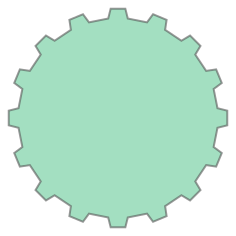

In [87]:
radius = 100
cog, side_length=generate_cog(16, radius, tooth_ratio=0.5)
cog

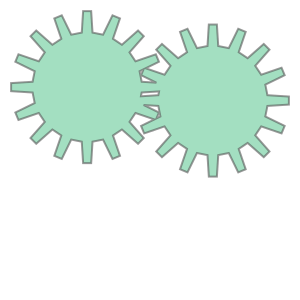

In [83]:
cog2 = shapely.affinity.translate(cog, 2 * radius + 1.5 * side_length, -1.25 * side_length)
cogs = shapely.ops.cascaded_union([cog, cog2])
cogs

In [79]:
type(cogs)

shapely.geometry.polygon.Polygon

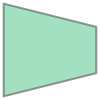

In [80]:
tooth = generate_rectangle_vertices(1, 1, [0, 0], 0)
tooth[[0, -1], 1] *= 0.5
shapely.geometry.Polygon(tooth)